Code for examining how HMM performs under repeated recalibration


In [196]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys, copy, re, os
from glob import glob
from utils.plotting.plotting_utils import figSize
from utils.simulation import simulation_utils
from utils.preprocessing import sweep_utils

import stabilizer_utils
from stabilizer_utils import Stabilizer
from hmm import HMMRecalibration
import hmm_utils

from sklearn.linear_model import LinearRegression
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib as mpl

def plotStretchData(session_scores, labels, colors, days_between = 0, ordering = None, toggleSE=False):
    '''Plot simulated data. Inputs are:
    
        session_scores (3D float) - reps x days x methods
        labels (list of str)      - labels of each method
        colors (list of str)      - colors for plotting each method '''

    n_sessions  = session_scores.shape[1] - 1
    
    if ordering is None:
        ordering = np.argsort(session_scores[:, -1, :].mean(axis = 0))[::-1]

    days     = np.linspace(0, (days_between + 1) * n_sessions, n_sessions + 1)
    fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})

    # plot data across time
    plt.axes(axs[0])
    for i in ordering:
        plotsd(data = session_scores[:, :, i], time_bins = days, color = colors[i],
               toggleSE = toggleSE, label = labels[i])

    axs[0].legend(loc = 'upper left')
    axs[0].set_title('Recalibration performance across time')
    axs[0].set_xlabel('Days')
    axs[0].set_ylabel('Trial Time (sec)')
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[0].set_ylim([0, 11])
    axs[0].set_yticks([0, 10])

    # and now the results on final day
    plt_data = [session_scores[:, -1, i].flatten() for i in ordering]
    cmap     = dict(zip(np.arange(len(labels)), np.asarray(colors)[ordering]))
    sns.stripplot(data = plt_data, palette = cmap, ax = axs[1], alpha = 0.7)

    sns.boxplot(medianprops={'ls': '-', 'lw': 2, 'alpha' : 0.6}, whiskerprops={'visible': False},
                zorder=1, data=plt_data, showfliers=False, showbox=False, showcaps=False, ax=axs[1])

    for i, line in enumerate(axs[1].get_lines()):
        line.set_color(cmap[np.floor(i/3).astype(int)])

    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['left'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].set_yticks([])
    axs[1].set_xticklabels(np.asarray(labels)[ordering], rotation = 45)
    axs[1].set_ylim([0, 11])
    
    return axs



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load simulation runs data

In [179]:
# we ran two batches (original sweep, and updated with static approaches) - combine below
# we'll keep the static FA sweep from batch 1

data_dirs = ['/oak/stanford/groups/henderj/ghwilson/nonstationarities/simulator/performance/',
        '/oak/stanford/groups/henderj/ghwilson/nonstationarities/simulator/performance_static/']

labels_set = [['Gain', 'Supervised', 'PRI-T', 'Stabilizer', 'Stabilizer (static)','RTI'],
              ['Gain', 'Supervised', 'PRI-T (static)', 'Stabilizer (static)', 'RTI (static)']
             ]

fig_path = '/home/users/ghwilson/projects/nonstationarities/figures/'

scores_list = list()
for data_dir, labels in zip(data_dirs, labels_set):

    files    = glob(data_dir + '*.npy')

    idxs = [int(re.findall('_(\d+).npy', x)[0]) for x in files]
    print('Missing:', np.setdiff1d(np.arange(max(idxs)), idxs))

    rep_data = list()
    for f in files:
        rep_data.append(np.load(f))

    session_scores = np.vstack(rep_data)[:, :, :len(labels)]
    scores_list.append(session_scores)
    print(session_scores.shape)

    
session_scores = np.dstack(scores_list)
labels = sum(labels_set, []) #np.concatenate(labels_set)

# remove redundant sweep components from second batch:
entries_to_remove = [6, 7, 9]
session_scores = np.delete(session_scores, entries_to_remove, axis=-1)

labels = [labels[i] for i in range(len(labels)) if i not in entries_to_remove]

Missing: []
(200, 61, 6)
Missing: []
(200, 61, 5)


#### Methods comparison


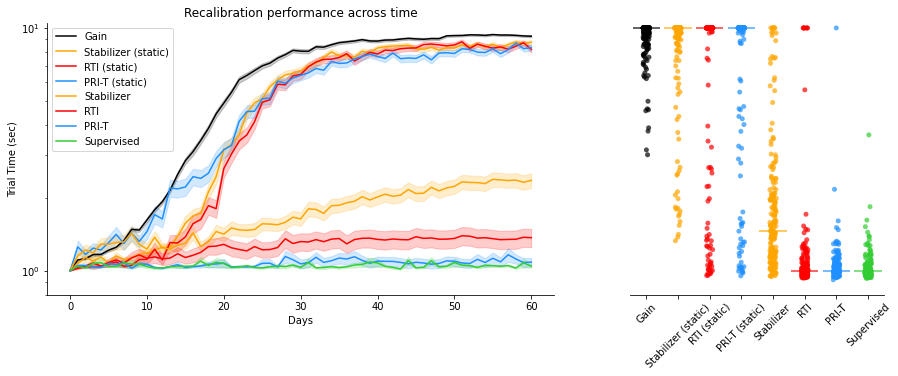

In [203]:
figSize(5, 15)
from lineplots import plotsd
import seaborn as sns 

# Original plot from bioRxiv paper:
#subset_labels = ['Gain', 'Supervised', 'PRI-T', 'Stabilizer', 'Stabilizer (static)', 'RTI']
#subset_colors = ['k', 'g', 'b', 'pink', 'orange', 'red']

subset_labels = ['Gain', 'Stabilizer (static)','RTI (static)', 'PRI-T (static)', 
                 'Stabilizer',  'RTI', 'PRI-T',  'Supervised']
subset_colors = ['k', 'orange', 'red', 'dodgerblue', 'orange', 'red', 'dodgerblue', 'limegreen']

log_plot = True
toggleSE = True

# ------------------------------------
idxs        = [labels.index(x) for x in subset_labels]
subset_data = session_scores[:, :, idxs]
#ordering    = np.argsort(subset_data[:, -1, :].mean(axis = 0))[::-1]
ordering    = np.arange(len(idxs))

axs = plotStretchData(subset_data, subset_labels, subset_colors, ordering = ordering, toggleSE=toggleSE)

if log_plot:
    # avoid massive PolyCollection shapes from being saved that mess with Illustrator
    for obj in axs[0].get_children():
        if isinstance(obj, mpl.collections.PolyCollection):
            idxs = obj.get_paths()[0].vertices[:, 1] < 0.8
            obj.get_paths()[0].vertices[idxs, 1] = 0.8

    for ax in axs:
        ax.set_ylim([0.8, 10.5])
        ax.set_yscale('log', base=10)
    

axs[1].set_yticks([])
axs[1].minorticks_off()


#plt.savefig(os.path.join(fig_path, 'simulator', 'repeated_recal_MainResult'), format = 'pdf')
plt.show()


In [202]:
import scipy

for i in range(len(subset_labels)):
    print('--------------', subset_labels[ordering[i]], '-----------------')
    grpdata1 = subset_data[:, -1, ordering[i]]
    print('TTT, mean +- SD: {:.3f} {:.3f}'.format(np.mean(grpdata1), np.std(grpdata1)))
    print('Percentage failed sessions: ', np.mean(grpdata1 > 5))
    print('\n')
    for j in range(len(subset_labels)):
        if j > i:
            grpdata2 = subset_data[:, -1, ordering[j]]
            print('{} and {}: \n'.format(subset_labels[ordering[i]], subset_labels[ordering[j]]), scipy.stats.ranksums(grpdata1, grpdata2) )
            print('\n')


-------------- Gain -----------------
TTT, mean +- SD: 9.257 1.387
Percentage failed sessions:  0.965


Gain and Stabilizer (static): 
 RanksumsResult(statistic=-0.565673963002499, pvalue=0.5716154380980005)


Gain and RTI (static): 
 RanksumsResult(statistic=-2.225070748966252, pvalue=0.02607648904594871)


Gain and PRI-T (static): 
 RanksumsResult(statistic=-1.9867784296892053, pvalue=0.04694695598979572)


Gain and Stabilizer: 
 RanksumsResult(statistic=15.877361012011274, pvalue=9.092410903068081e-57)


Gain and RTI: 
 RanksumsResult(statistic=16.398922785238348, pvalue=1.946591232732718e-60)


Gain and PRI-T: 
 RanksumsResult(statistic=17.171318578757052, pvalue=4.354153555974254e-66)


Gain and Supervised: 
 RanksumsResult(statistic=17.297168061351645, pvalue=4.940866681939469e-67)


-------------- Stabilizer (static) -----------------
TTT, mean +- SD: 8.733 2.524
Percentage failed sessions:  0.88


Stabilizer (static) and RTI (static): 
 RanksumsResult(statistic=-1.3661804656918